<a href="https://colab.research.google.com/github/niduttnb/Image-Based-Product-Recommendation/blob/main/Dimension_Reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**The Following is dimension reduction notebook originally run on AWS instance with 196GB RAM. Depending on your config, this might not work. It ran out of RAM on 32GB COLAB Pro.**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # accessing directory structure
import cv2
import csv


In [ ]:
import boto3
# import required module
import os
import re
from collections import defaultdict


**Read dataset from my S3 bucket. Masked my AccessKey and SecretAccess Key**

In [ ]:
AWS_S3_BUCKET = 'sml-project-churn'
AWS_ACCESS_KEY_ID = ''
AWS_SECRET_ACCESS_KEY = ''

s3_client = boto3.client(
    "s3",
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
)

response = s3_client.get_object(Bucket=AWS_S3_BUCKET, Key="df_new.csv")

status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")

if status == 200:
    print(f"Successful S3 get_object response. Status - {status}")
    df = pd.read_csv(response.get("Body"))
    print(df.head())
else:
    print(f"Unsuccessful S3 get_object response. Status - {status}")

response = s3_client.get_object(Bucket=AWS_S3_BUCKET, Key="df_embs.csv")

status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")

if status == 200:
    print(f"Successful S3 get_object response. Status - {status}")
    df_embs = pd.read_csv(response.get("Body"))
    print(df_embs.head())
else:
    print(f"Unsuccessful S3 get_object response. Status - {status}")

Successful S3 get_object response. Status - 200
   Unnamed: 0     id gender masterCategory subCategory  articleType  \
0           0  15970    Men        Apparel     Topwear       Shirts   
1           1  39386    Men        Apparel  Bottomwear        Jeans   
2           2  21379    Men        Apparel  Bottomwear  Track Pants   
3           3  53759    Men        Apparel     Topwear      Tshirts   
4           4   1855    Men        Apparel     Topwear      Tshirts   

  baseColour  season    year   usage  \
0  Navy Blue    Fall  2011.0  Casual   
1       Blue  Summer  2012.0  Casual   
2      Black    Fall  2011.0  Casual   
3       Grey  Summer  2012.0  Casual   
4       Grey  Summer  2011.0  Casual   

                              productDisplayName      image  
0               Turtle Check Men Navy Blue Shirt  15970.jpg  
1             Peter England Men Party Blue Jeans  39386.jpg  
2  Manchester United Men Solid Black Track Pants  21379.jpg  
3                          Puma Men 

In [ ]:
del df_embs['Unnamed: 0']
del df['Unnamed: 0']

In [ ]:
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
3,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg
4,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt,1855.jpg


**1) Running PCA on my Data to convert it into 100 dimension Vector. Post that i run TSNE to convert to 2 dimension**

In [ ]:
from sklearn.decomposition import PCA,KernelPCA

pca = PCA(n_components=100, random_state=22)
pca.fit(df_embs)
df_embed_pca = pca.transform(df_embs)

df_embed_pca = pd.DataFrame(df_embed_pca)

In [ ]:
from sklearn.manifold import TSNE
import time
import seaborn as sns

In [ ]:
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_embed_pca)

df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

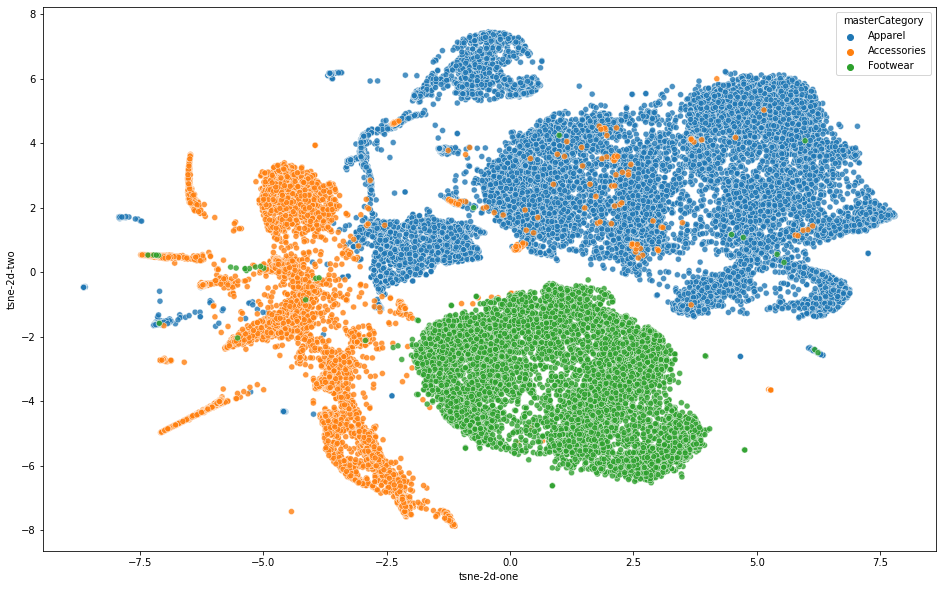

In [ ]:
tsne_plot = plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="masterCategory",
                data=df,
                legend="full",
                alpha=0.8)

In [ ]:
tsne_plot.savefig("out2.png") 

**2) Now let's run KernelPCA(100 dimension) on our dataset. I later store it as a csv**

In [ ]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=100, random_state=22)
kpca.fit(df_embs)
df_embed_kpca = kpca.transform(df_embs)

df_embed_kpca = pd.DataFrame(df_embed_kpca)

In [ ]:
df_embed_kpca.to_csv('kpcaNew.csv')

In [ ]:
import pickle as pk
pk.dump(kpca, open("kpca2.pkl","wb"))

**3) Now let's run IsoMap(100 dimension) on our dataset. I later store it as a csv**

In [ ]:
from sklearn import manifold

iso = manifold.Isomap(n_neighbors=6, n_components=100)
iso.fit(df_embs)
isomap_100 = iso.transform(df_embs)
isomap_100 = pd.DataFrame(isomap_100)

# Left with 2 dimensions
isomap_100.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,974.462921,-163.807978,142.190683,-12.449625,-199.663966,120.355897,-436.840639,135.550872,-75.197467,150.892294,...,-3.913935,11.659270,21.011131,-10.708939,40.303502,20.983968,-2.893423,31.212859,-28.716344,-10.154044
1,830.964073,377.877374,-572.533268,-149.545789,556.179706,-131.477119,-186.827292,315.185330,20.634397,-188.062006,...,-13.233004,-17.360788,23.234612,28.853261,29.587115,38.762937,22.523494,-47.726177,-6.417220,4.774191
2,829.624793,301.767294,-603.864687,-153.245649,482.108388,-136.375600,-215.589093,294.641987,26.382629,-190.748419,...,37.185473,37.164440,20.072078,57.681576,-49.433918,-6.516495,45.874931,5.158822,28.936740,7.407979
3,969.443183,-261.160368,-53.419310,151.538851,7.762421,-227.412339,-38.695933,-47.416711,-4.176650,19.294455,...,16.003066,-15.114429,5.296475,-38.698218,-28.626259,-58.790004,96.598363,19.923117,67.337760,-39.465711
4,867.523140,-67.474539,-144.580940,339.435088,-62.636074,-190.583834,142.200683,-163.050137,-70.816030,-139.016411,...,-12.587589,-17.004631,10.259834,-49.850979,62.265495,28.039239,30.137575,-45.272392,62.704459,-45.851510


In [ ]:
df_embed_kpca.to_csv('df_embed_kpca.csv')

In [ ]:
isomap_100.to_csv('isomap_100.csv')

**4) Now let's run IsoMap(2 dimension) on our dataset. I later store it as a csv**

In [ ]:
from sklearn import manifold

iso = manifold.Isomap(n_neighbors=6, n_components=2)
iso.fit(df_embs)
isomap_2 = iso.transform(df_embs)
isomap_2 = pd.DataFrame(isomap_2)

# Left with 2 dimensions
isomap_2.head()

,0,1
0,974.462921,-163.807978
1,830.964073,377.877374
2,829.624793,301.767294
3,969.443183,-261.160368
4,867.523140,-67.474539


In [ ]:
isomap_2.to_csv('isomap_2.csv')